# Exploring Community Structure in Amazon's Copurchased Product Network (Restricted to Mathematics Related Materials)

## Introduction

Millions of people purchase products from Amazon every day with many products being purchased in the same order. Knowledge of how customers group their purchases is extremely valuable to sellers who wish to advertise similar products that may complement an order. By building a network of copurchased products, marketing analysts are able to make meaningful insights into consumer behavior. Community detection algorithms are often used to group similar products together. In this notebook, we explore the community structure of copurchased mathematics materials and investigate information found in the metadata that may help determine why some products are frequently purchased together.

## Methods

To alleviate some of the proccessing time and storage, the data from ```amazon-meta.txt``` (found at https://snap.stanford.edu/data/amazon-meta.html) was reduced to the file ```mathproducts.txt``` which is provided in the same folder as this notebook. This reduced file contains only the metadata entries found in ```amazon-meta.txt``` that have the category 'Mathematics' listed under the field 'categories'. Since we are only concerned with products in the Mathematics category, this information should allow us to explore the question "what are the communities in the network of co-purchased books on Amazon (circa 2003) restricted to the categories ‘Mathematics’ and ‘Math’?"

### Useful Data
We begin by taking setting up a python dictionary to hold the metadata and make it easier for us to access. The class ```AMZN_Product``` will allow us to access title information as well as similar products which we will make use of later. First, we must construct the dictionary of products found in the metadata file.

To do so, we need an appropriate key/value pair. Luckily, each product in ```mathproducts.txt``` has an identifier known as the Amazon Standard Identification Number (ASIN). For books, this number is the same as the International Standard Book Number, or ISBN. We use these ASINs as the keys for the python dictionary ```math_dict``` with the values of ```math_dict``` being references to corresponding instances of ```AMZN_Product```. To find out more about Amazon's identification system visit:
https://www.amazon.com/gp/seller/asin-upc-isbn-info.html

In [1]:
class AMZN_Product:
    def __init__(self, Id, ASIN):
        self.ID = Id
        self.asin = ASIN
        self.similar = []
    
    def __repr__(self):
        p_string = 'Id: {}\tASIN: {}\nTitle: {}\nGroup: {}\tSales Rank: {}\n\tSimilar: {}\nReviews:\tTotal:{}\tDownloaded:{}\tAvg Rating:{}\n'
        return p_string.format(self.ID,self.asin,self.title,self.group,self.salesrank,self.similar,self.reviews[0],self.reviews[1],self.reviews[2])
  
    def set_title(self, title):
        self.title = title
  
    def set_group(self, group):
        self.group = group
    
    def set_salesrank(self, rank):
        self.salesrank = rank
  
    def add_similar(self, asin):
        self.similar.append(asin)
    
    def set_reviews(self, total, downloaded, avgrating):
        self.reviews = (total,downloaded,avgrating)

In [2]:
def data_to_dict(filename):
    product_dict = {}
    
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            if 'Id:' in line:
                ID = line.split()[-1]
                next_line = f.readline()
                ASIN = next_line.split()[-1]
                product_dict[ASIN] = AMZN_Product(int(ID), ASIN)

                # title
                next_line = f.readline().lstrip('title: ')
                if 'discontinued product' not in next_line:
                    product_dict[ASIN].set_title(next_line.rstrip('\n'))
                    # group
                    next_line = f.readline().split()[-1]
                    product_dict[ASIN].set_group(next_line)

                    # salesrank
                    next_line = f.readline().split()[-1]
                    product_dict[ASIN].set_salesrank(int(next_line)) 

                    # similar
                    next_line = f.readline().split()[2:]
                    for item in next_line:
                        product_dict[ASIN].add_similar(item)
                else:
                    # Remove discontinued products
                    product_dict.pop(ASIN)

            if 'reviews:' in line:
                # reviews
                r = line.split()
                product_dict[ASIN].set_reviews(int(r[2]),int(r[4]),float(r[-1]))

    return product_dict

In [3]:
math_dict = data_to_dict('mathproducts.txt')
print(len(math_dict))

6716


### Converting Metadata into a Networkx Structure
There are 6716 products in the product dictionary ```math_dict``` which we use to generate a network of copurchased products. To do this, we need to import networkx and iterate over the ASINs found in each products ```similar``` attribute and add an edge to the network. This edge indicates that the two products were frequently purchased together.

In [4]:
import networkx as nx

G = nx.Graph()
for item in math_dict:
    for s in math_dict[item].similar:
        G.add_edge(item,s)

### Visualizing the Network

A simple visualization that is useful for examining structure in small networks is a two-dimensional plot of the adjacency matrix. Here, the adjacency matrix is so sparse and the number of vertices (products) so large that we cannot really gain much insight by inspecting the plot of the adjacency matrix. One thing we may be able to verify visually is that the adjacency matrix should be symmetric since we have constructed a network with undirected edges. And that does appear to be the case.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_matrix(M):
    f = plt.figure(figsize=[10,10])
    ax = plt.Axes(f, [0., 0., 1., 1.])
    f.add_axes(ax)

    ax.matshow(M, cmap='Greys',  interpolation='nearest')
    ticks = []
    for i in range(M.shape[0]):
        ticks.append(str(int(i+1)))
    ax.set_xticklabels(['']+ticks, minor=True)
    ax.set_yticklabels(['']+ticks, minor=True)
    ax.tick_params(length=0)
    plt.title('View of Adjacency Matrix')
    
    plt.show()
    plt.savefig('adj_matrix.png')
    
    plt.close(f)

plot_matrix(nx.to_numpy_matrix(G))

<Figure size 1000x1000 with 1 Axes>

### Products in Network Not Found in Metadata
Now that our network data structure ```G``` is in place, let's check the number of edges and nodes.

In [6]:
print(G.number_of_edges())
print(G.number_of_nodes())

22165
12877


Notice that the number of nodes has increased from 6716 to 12877.

It appears that there are many products that are frequently purchased with products found in the metadata, but these products may not actually be found in the metadata. Let's investigate by looking at the degree sequence of the network and finding the products with the highest degrees.

In [7]:
degree_sequence = [d for n, d in G.degree()]
degree_sequence_dict = sorted(G.degree, key=lambda x: x[1], reverse=True)
for item in degree_sequence_dict[0:5]:
    if item[0] in math_dict:
        print(math_dict[item[0]], 'Degree: {}'.format(item[1]))
    else:
        print(item[0], 'Degree: {}'.format(item[1]) )

0486428753 Degree: 183
0679454438 Degree: 125
158488388X Degree: 114
0521831431 Degree: 65
Id: 439583	ASIN: 0486414485
Title: Calculus of Variations
Group: Book	Sales Rank: 12808
	Similar: ['0486630692', '0486428753', '0486658406', '0486406830', '0486404552']
Reviews:	Total:6	Downloaded:6	Avg Rating:5.0
 Degree: 55


It appears that the four highest-degree products are not in our metadata. A search of the ASINs on Amazon finds the following products

`0486428753`: https://www.amazon.com/Counterexamples-analysis-Mathesis-Bernard-Gelbaum/dp/B0006BM8BW/

`0679454438`: https://www.amazon.com/Road-Reality-Complete-Guide-Universe/dp/0679454438/

`158488388X`: https://www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/158488388X/

`0521831431`: https://www.amazon.com/First-Course-String-Theory/dp/0521831431/

`0486414485`: https://www.amazon.com/Calculus-Variations-I-M-Gelfand/dp/0131122924/


These products are apparently all mathematics books so they should have been included in `math_products.txt` after restricting `amazon-meta.txt` to the Mathematics categories. In fact, they aren't located in `amazon-meta.txt` either as a search of their ASINs should reveal.

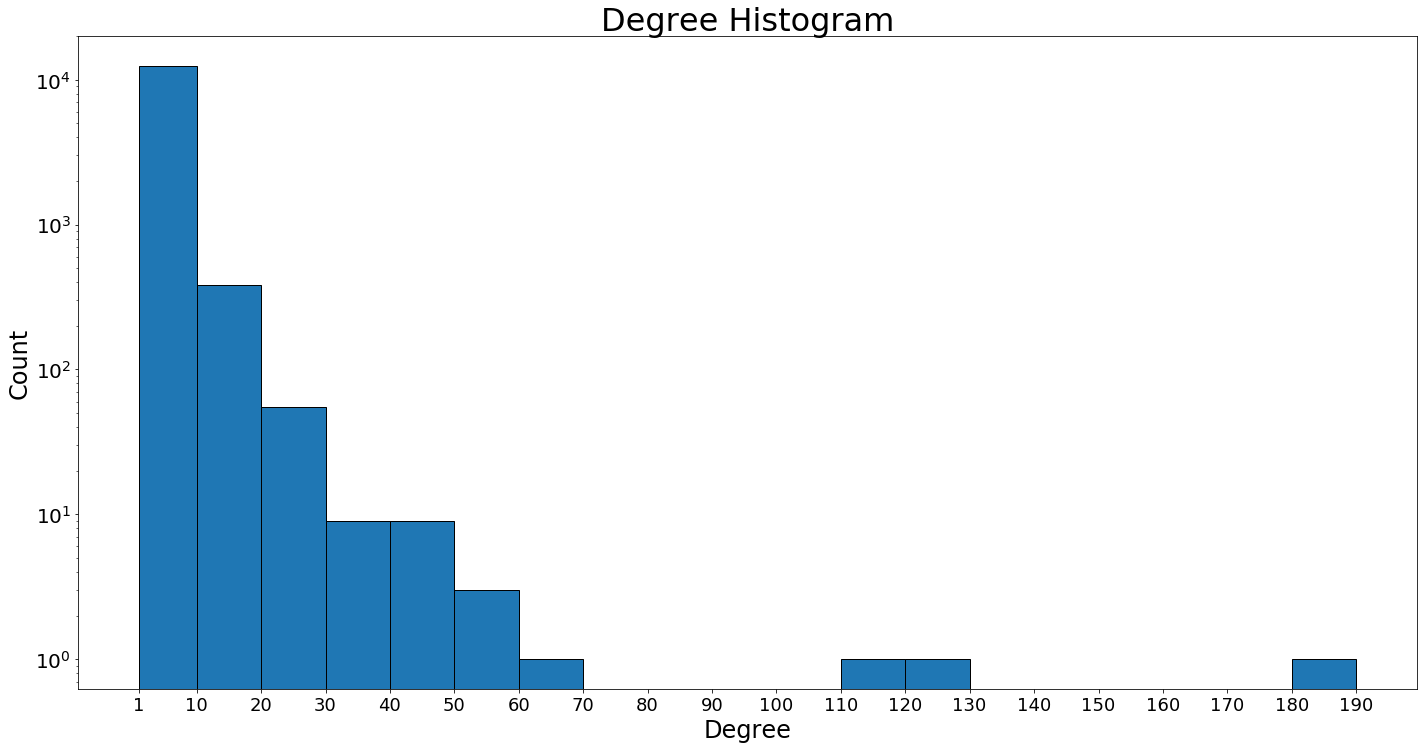

In [8]:
import collections

# fig, ax = plt.subplots()
fig = plt.figure(figsize=[24,12])
xt = [1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190]
plt.hist(degree_sequence, bins = xt, edgecolor='black', linewidth=1)
plt.yscale('log')
plt.yticks(fontsize=20)
plt.xticks(xt, fontsize=18)

plt.title("Degree Histogram",fontsize = 32)
plt.ylabel("Count",fontsize = 24)
plt.xlabel("Degree",fontsize = 24)

fig.savefig('deg_seq.png')
plt.show()

The degree histogram shows many nodes with low degree and only a few with high degree.

### Measuring clustering
The clustering coefficient of a product $u$ is a measure of how likely any pair of products are similar to each other given that both are similar to $u$. Notice that a wide range of clustering coefficients are present in this network.

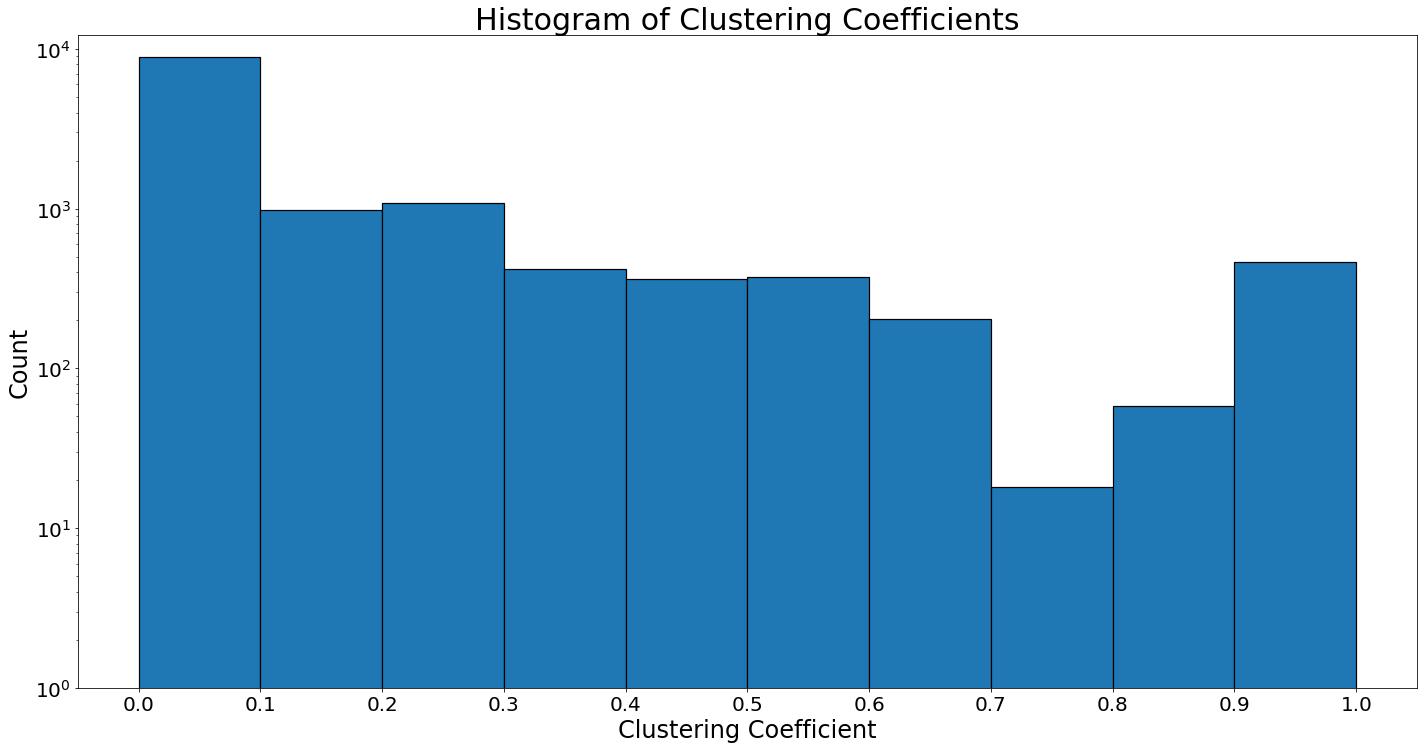

In [9]:
from networkx import algorithms as alg

cl_coeffs = alg.cluster.clustering(G)

f = plt.figure(figsize=[24,12])
plt.hist(cl_coeffs.values(), bins = np.arange(0,1.1,step=0.1),edgecolor='black', linewidth=1.2)
plt.title('Histogram of Clustering Coefficients',fontsize=30)
plt.xticks(np.arange(0,1.1,step=0.1), fontsize=20)
plt.yscale('log')
plt.yticks([1,10,100,1000,10000], fontsize=20)
plt.xlabel('Clustering Coefficient', fontsize=24)
plt.ylabel('Count', fontsize=24)

plt.savefig('ccHist.png')

In [10]:
print(np.mean(list(cl_coeffs.values())))
print(np.std(list(cl_coeffs.values())))

0.12149813120409578
0.23593944137914627


In [11]:
print(nx.number_connected_components(G))

# Find the largest connected component
cc = nx.connected_components(G)
largest_cc = max(cc, key=len)
print(len(largest_cc))

491
9757


### Connected Components
Examining the connected components of the network, we find that one component contains more than 75% of the products. We focus on this component and proceed with the analysis on this component alone.

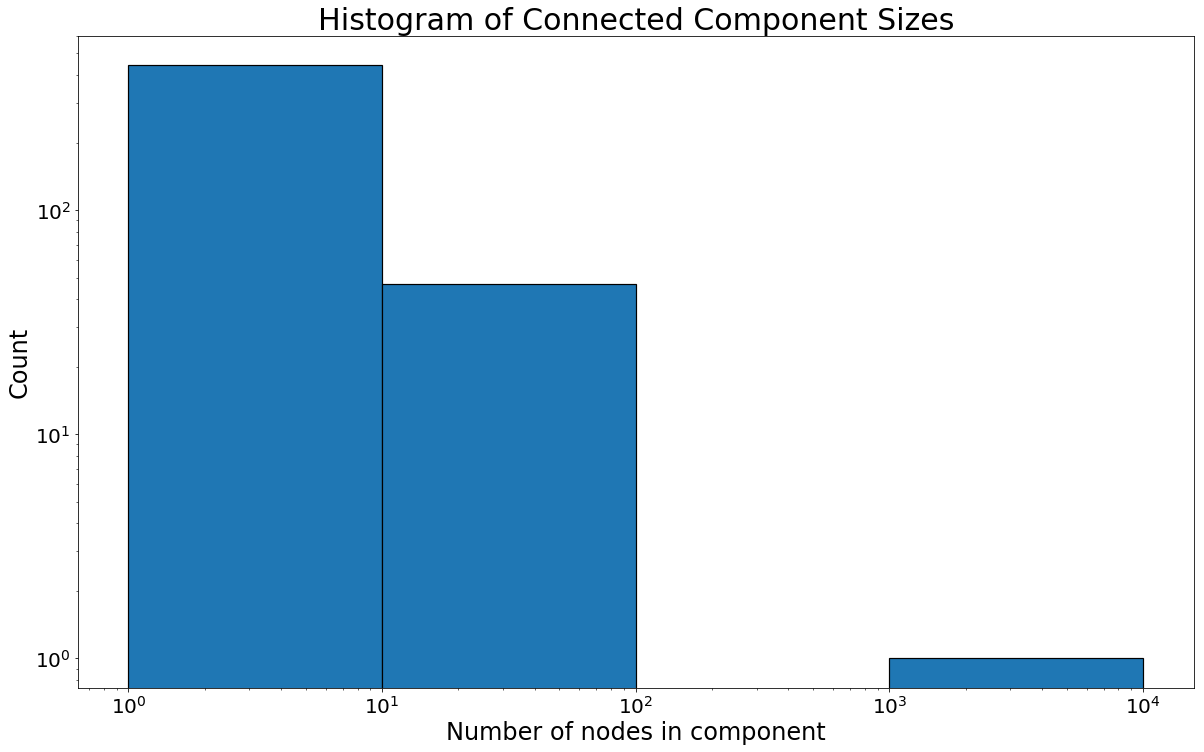

In [34]:
cc = nx.connected_components(G)
cc_size = []
for component in cc:
    cc_size.append(len(component))

xt = [1,10,100,1000,10000]
f = plt.figure(figsize=[20,12])
plt.hist(cc_size, bins = xt, edgecolor='black', linewidth=1.2)
plt.title('Histogram of Connected Component Sizes',fontsize=30)
plt.xscale('log')
plt.yscale('log')
plt.xticks(xt, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of nodes in component', fontsize=24)
plt.ylabel('Count', fontsize=24)

plt.savefig('ccSizeHist.png')


In [35]:
H = G.subgraph(largest_cc)
print(H.number_of_edges())
print(H.number_of_nodes())
# plot_matrix(nx.to_numpy_matrix(H))

19060
9757


In [14]:
from math import floor
def rgb2hex(rgb):
    r = floor(rgb[0]*255)
    g = floor(rgb[1]*255)
    b = floor(rgb[2]*255)
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

def draw_graph_from_communities(network, comm_list):
    f = plt.figure(figsize=[30,30])
    ax = plt.Axes(f, [0., 0., 1., 1.])
    ax.set_aspect('equal')
    ax.set_axis_off()
    f.add_axes(ax)
    
    pos = nx.kamada_kawai_layout(network)
#     pos = nx.shell_layout(network)
    
    # Create list of colors
    v_cmap = plt.cm.tab20
    
    nx.draw_networkx_edges(network,pos=pos, edge_color = 'gray')
    
    for e,c in enumerate(comm_list):
        H = network.subgraph(c)
        
        # Calculate betweenness centrality
        v_centrality = list(dict.values(nx.betweenness_centrality(H)))
        
        nx.draw_networkx_nodes(H, nodelist = c, pos = pos, node_color=rgb2hex(v_cmap(e)[:-1]))
        
        # Calculate betweenness centrality
        e_centrality = list(dict.values(nx.algorithms.centrality.edge_betweenness_centrality(H)))
        
        # Assign edge colormap
        e_cmap = plt.cm.viridis
        # Adjust color map by changing edge_cmap
        nx.draw_networkx_edges(H, pos = pos, edge_color = e_centrality, edge_cmap=e_cmap)
    
    
    plt.savefig('kclique_communities.png')
    plt.show()
    plt.close(f)

### Community Detection

The Girvan-Newman algorithm failed to run on this dataset, so the k-clique percolation method is used to detect communities. Using 3-clique percolation we build a visualization of the communities and their interaction with one another. With 3-clique percolation, triangles of nodes are considered to be adjacent if they share two nodes in common. Grouping these adjacent triangles gives rise to distinct communities in the network.

In [15]:
from networkx.algorithms import community

def get_communities(G,k):
    '''Returns a list of all k-clique communities'''
    communities_generator = community.k_clique_communities(G,k)
    
    return sorted(list(communities_generator),key=len,reverse=True)

def get_top_n_communities_subgraph(G, comm_list,n):
    '''Returns a subgraph containing only the nodes from the top n communities'''
    community_nodes = set()
    for i in range(n):
        for node in list(comm_list[i]):
            community_nodes.add(node)
    return G.subgraph(list(community_nodes))

564


/opt/conda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


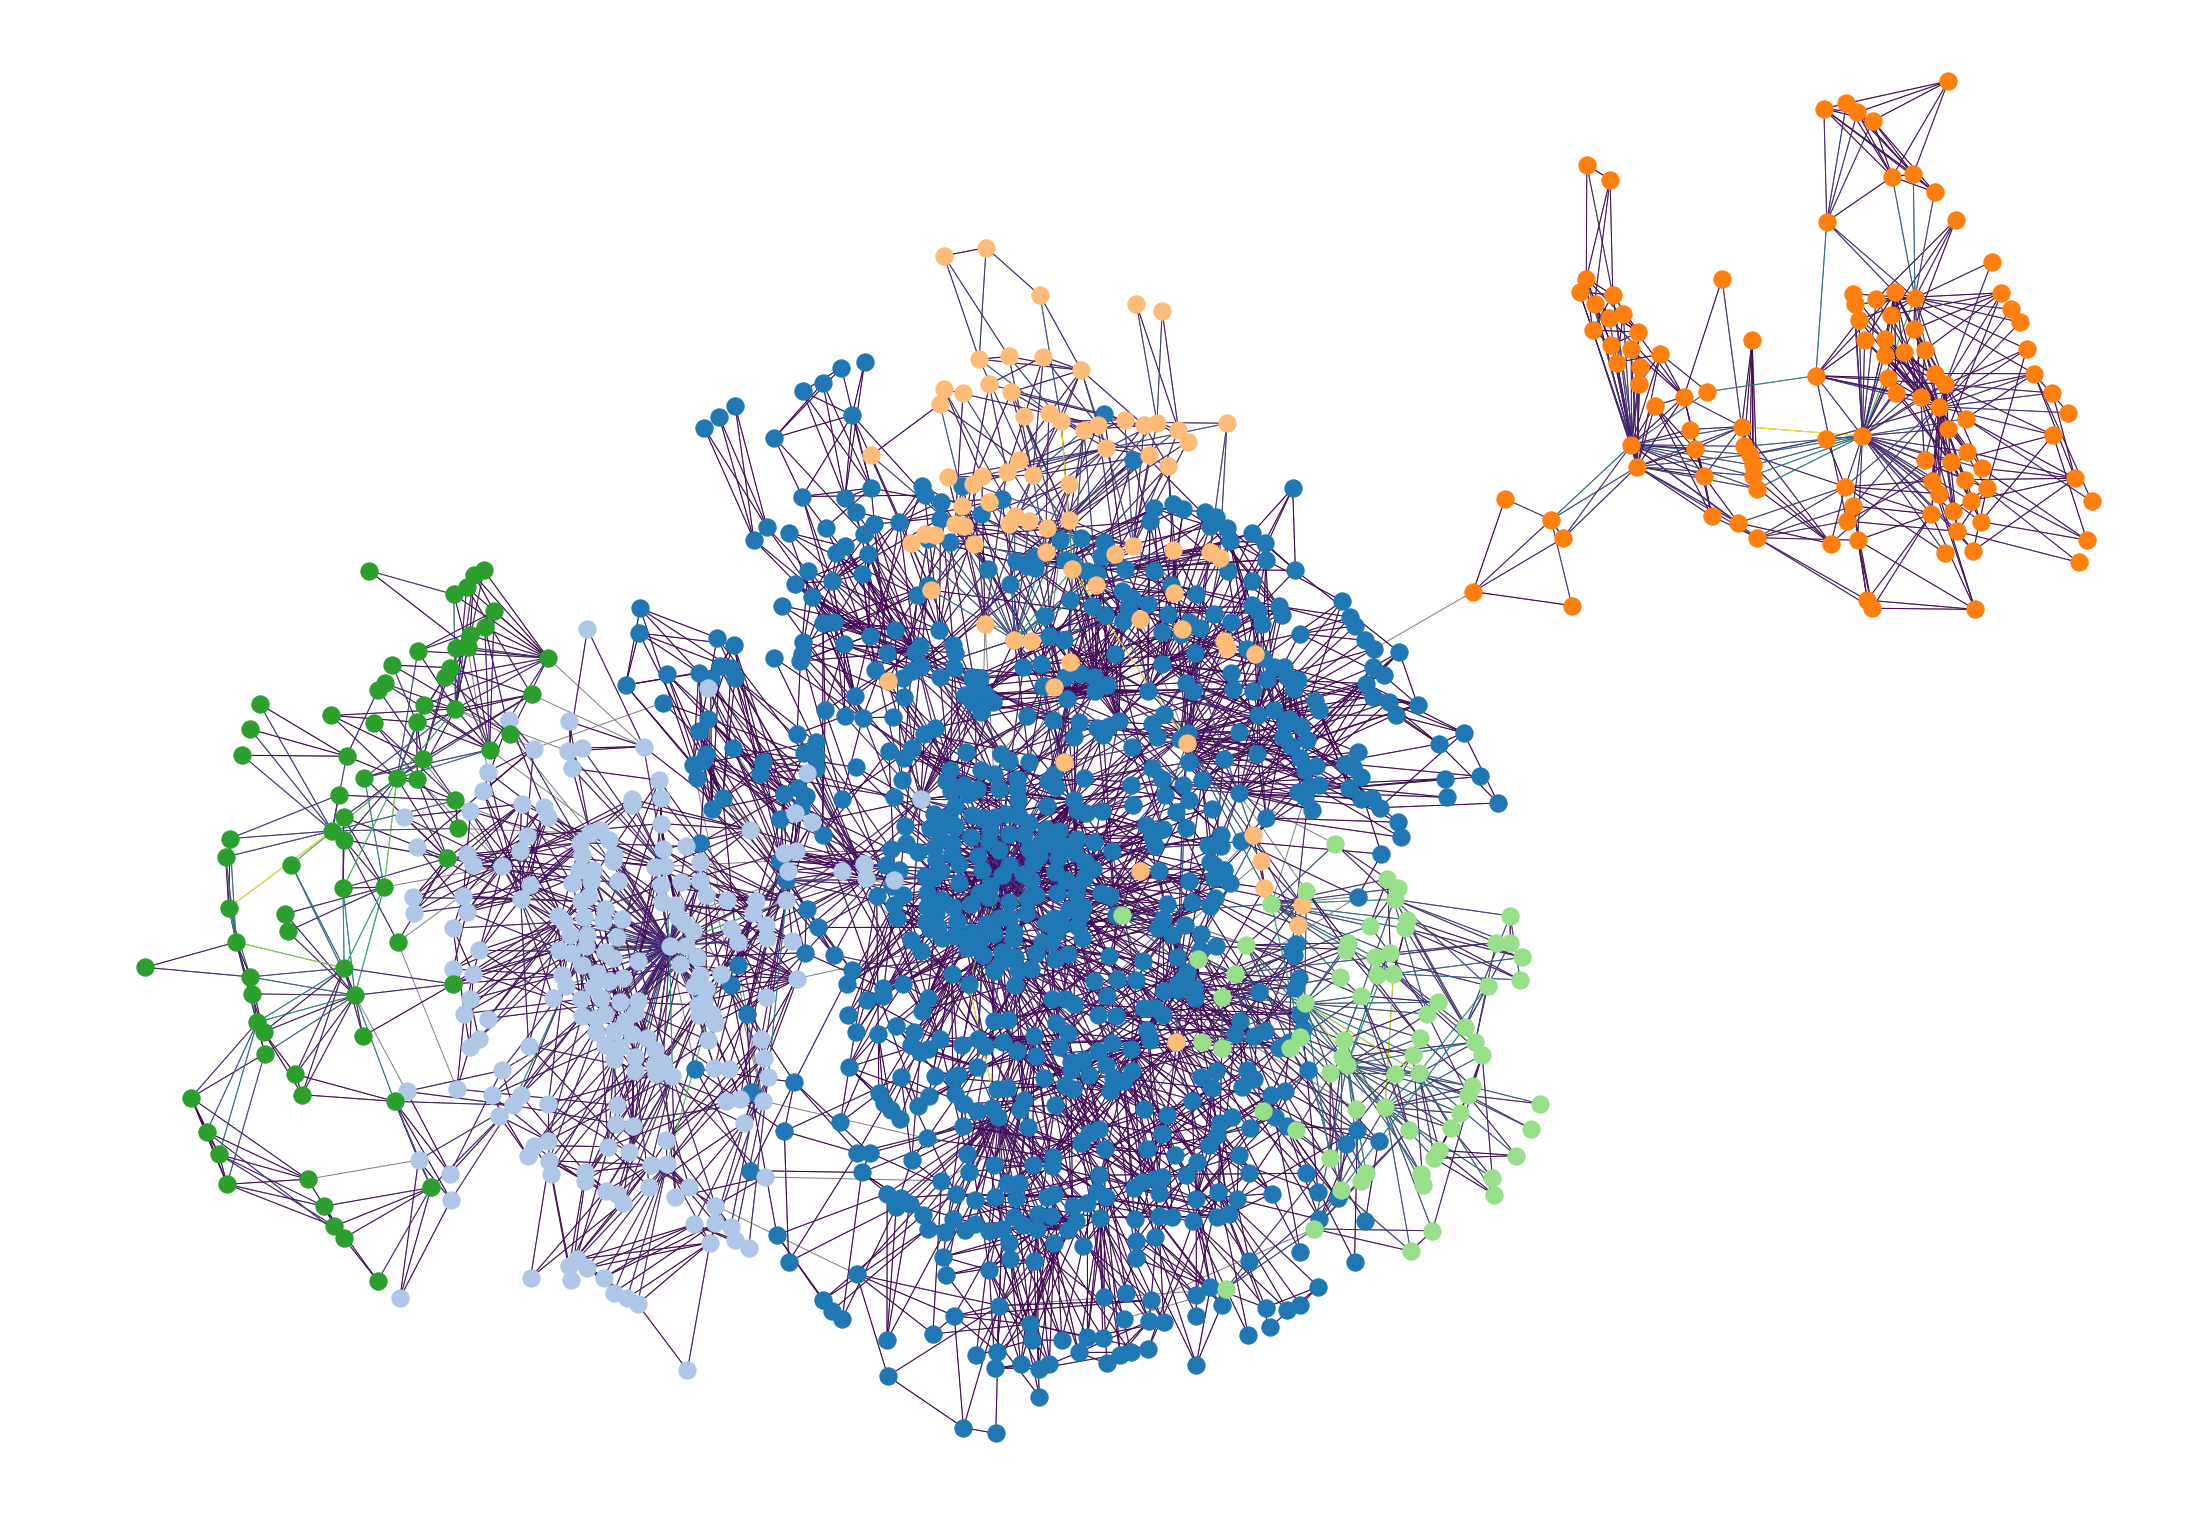

In [16]:
num_communities=6
k=3
comms = get_communities(G,k)
print(len(comms))
community_subgraph = get_top_n_communities_subgraph(G,comms,num_communities)
draw_graph_from_communities(community_subgraph, comms[:num_communities])

### Basic Linguistic Analysis
Do the communities found using the k-clique percolation method split the products into sensible groups?
There are several fields in the metadata that we can explore, perhaps most noticeable is the title. 
We can look at the words used in the title and look for patterns.
First, we create a few helpful functions that will allow us to create a histogram of words that appear frequently in titles.

In [17]:
def get_words(ASIN):
    return set(math_dict[ASIN].title.lower().split())

def get_word_freq(booklist):
    word_freq_dict ={}
    remove_words = {':','the','a','an','of','in','and','for','to','is','on','from','with'}
    translation_table = dict.fromkeys(map(ord, '!@#$()'), None)
    for book in booklist:
        
        if book in math_dict:
            words = get_words(book)
        
            for word in words:
                word = word.translate(translation_table)
                if word not in remove_words:
                    if word in word_freq_dict.keys():
                        word_freq_dict[word] += 1
                    else:
                        word_freq_dict[word] = 1    
    
#     word_freq_list = map(list, word_freq_dict.items())
    word_freq_list = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)
    
    return word_freq_list

In [32]:
import matplotlib.gridspec as gridspec

def plot_word_freq(communities):
    rows = 3
    cols = 2
    f = plt.figure(figsize=[20,18])
    gs = gridspec.GridSpec(rows, cols, hspace=2, wspace=.3)
    f.suptitle('Most Common Words Used in Title', fontsize=28)
    
    # Number of words to plot
    num_words = 10
    
    # Subplots
    ax = [[None]*cols]*rows
    for i in range(rows):
        for j in range(cols):
            cnum = cols*i+j+1
            cstr = 'community '+str(cnum)
            community = list(communities[cnum-1])
            # build 2d array with word and its frequency (only once per book)
            word_freq = get_word_freq(community)
            
            # Get top 10 words and group all others
            others = sum(word[1] for word in word_freq[num_words:])
            labels = [word[0] for word in word_freq[:num_words]]
            counts = [word[1] for word in word_freq[:num_words]]
            
            ax[i][j] = plt.subplot(gs[i,j])
            plt.title(cstr)
            plt.bar(range(1,num_words+1), counts, edgecolor='black', linewidth=1)
            plt.title(cstr,fontsize=30)
            plt.xticks(range(1,num_words+1),labels, rotation='vertical', fontsize=20)
            plt.yticks(fontsize=20)
#             plt.xlabel('Word', fontsize=24)
            plt.ylabel('Number of books', fontsize=18)

### Results
The histogram of frequently used words shows a noticeable difference in the titles between some communities.

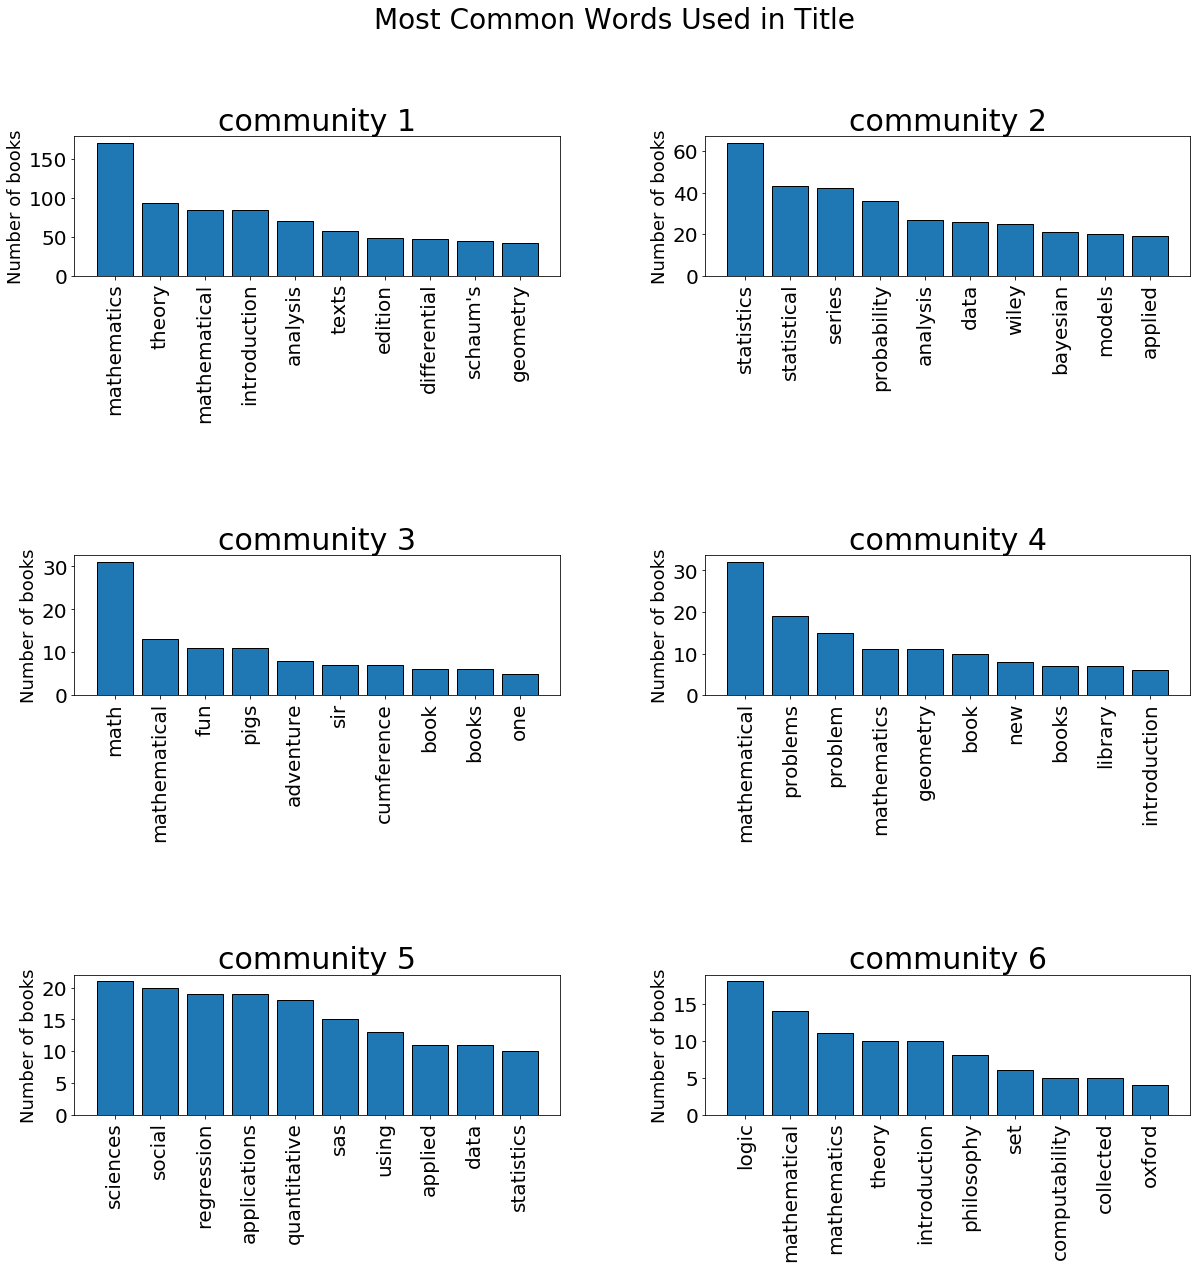

In [33]:
plot_word_freq(list(comms))
plt.savefig('Common')

## Conclusion


A comparison of the results of the k-clique percolation method with a linguistic analysis of the titles finds that there is potential predictive power in the metadata. Further analysis may include a comparison of salesrank within each community and a deeper look at network measures like edge centrality.